# Cohort Retention Analysis

When and how do users disengage from the platform?

In [75]:
from google.cloud import bigquery
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings('ignore')
load_dotenv()

GCP_PROJECT = os.environ.get("GCP_PROJECT")
client = bigquery.Client(project=GCP_PROJECT)

def run_query(sql):
    return client.query(sql).to_dataframe()

## Data Assessment

Retention can be measured by subscription status or by product activity. The following checks assess which approach the data supports.

In [76]:
# Transaction coverage for users registered 2015+
run_query("""
SELECT 
    COUNT(DISTINCT m.msno) as total_users,
    COUNT(DISTINCT t.msno) as users_with_transactions,
    ROUND(COUNT(DISTINCT t.msno) * 100.0 / COUNT(DISTINCT m.msno), 1) as pct_with_transactions
FROM kkbox.members m
LEFT JOIN kkbox.transactions t ON m.msno = t.msno
WHERE m.registration_init_time >= 20150101
""")

,total_users,users_with_transactions,pct_with_transactions
0,4348970,475005,10.9


In [77]:
# Membership expiration dates relative to data end (Feb 2017)
run_query("""
SELECT 
    CASE 
        WHEN membership_expire_date > 20170228 THEN 'After data ends'
        ELSE 'Before data ends'
    END as expiration_window,
    COUNT(DISTINCT msno) as users
FROM kkbox.transactions
GROUP BY expiration_window
""")

,expiration_window,users
0,After data ends,1196916
1,Before data ends,351


Transaction coverage is incomplete (10.9%), and the vast majority of membership expiration dates extend beyond the observation window. Subscription-based retention is not feasible with this data structure.

## Defining Cohorts

Based on the data limitations above, this analysis uses activity-based retention: whether users had any listening activity in each month after registration.

In [66]:
# Registration date range
run_query("""
SELECT 
    MIN(registration_init_time) as earliest,
    MAX(registration_init_time) as latest
FROM kkbox.members
""")

,earliest,latest
0,20040326,20170429


Registrations span March 2004 to April 2017, over 13 years. Cohort retention will focus on users who registered January 2015 onwards since that's when user_logs data begins.

In [67]:
# Registration distribution by year
run_query("""
SELECT 
    EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', CAST(registration_init_time AS STRING))) as reg_year,
    COUNT(*) as user_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) as pct_of_total
FROM kkbox.members
GROUP BY reg_year
ORDER BY reg_year
""")

,reg_year,user_count,pct_of_total
0,2004,26234,0.4
1,2005,41349,0.6
2,2006,53953,0.8
3,2007,89830,1.3
4,2008,67690,1.0
5,2009,63633,0.9
6,2010,115075,1.7
7,2011,179051,2.6
8,2012,283190,4.2
9,2013,524722,7.8


Registration grew significantly over time. 2015-2016 account for the majority (3.9M of 6.8M users).

In [68]:
# User logs date range
run_query("""
SELECT 
    MIN(date) as earliest_activity,
    MAX(date) as latest_activity
FROM kkbox.user_logs
""")

,earliest_activity,latest_activity
0,20150101,20170228


User logs span Jan 2015 to Feb 2017 (25 months). Cohorts are defined by registration month, and retention is measured by whether users had any listening activity in subsequent months.

In [69]:
# Assign cohorts by registration month (all users, not just train set)
run_query("""
SELECT 
    FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', CAST(registration_init_time AS STRING))) as cohort_month,
    COUNT(*) as users
FROM kkbox.members
WHERE registration_init_time >= 20150101
  AND registration_init_time <= 20160831
GROUP BY cohort_month
ORDER BY cohort_month
""")

,cohort_month,users
0,2015-01,102290
1,2015-02,92790
2,2015-03,95388
3,2015-04,80934
4,2015-05,71404
5,2015-06,79167
6,2015-07,111526
7,2015-08,161470
8,2015-09,119370
9,2015-10,235884


Cohorts include all users who registered between Jan 2015 and Aug 2016. The cutoff at Aug 2016 ensures at least 6 months of follow-up time before the data ends (Feb 2017).

In [70]:
# Build retention matrix: for each cohort, what % are active in subsequent months
run_query("""
WITH user_cohort AS (
    SELECT 
        msno,
        FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', CAST(registration_init_time AS STRING))) as cohort_month
    FROM kkbox.members
    WHERE registration_init_time >= 20150101
      AND registration_init_time <= 20160831
),
user_activity AS (
    SELECT DISTINCT
        msno,
        FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', CAST(date AS STRING))) as activity_month
    FROM kkbox.user_logs
),
cohort_size AS (
    SELECT cohort_month, COUNT(*) as users
    FROM user_cohort
    GROUP BY cohort_month
)
SELECT 
    uc.cohort_month,
    DATE_DIFF(
        PARSE_DATE('%Y-%m', ua.activity_month), 
        PARSE_DATE('%Y-%m', uc.cohort_month), 
        MONTH
    ) as months_since_registration,
    COUNT(DISTINCT uc.msno) as active_users,
    cs.users as cohort_size
FROM user_cohort uc
JOIN user_activity ua ON uc.msno = ua.msno
JOIN cohort_size cs ON uc.cohort_month = cs.cohort_month
WHERE DATE_DIFF(
        PARSE_DATE('%Y-%m', ua.activity_month), 
        PARSE_DATE('%Y-%m', uc.cohort_month), 
        MONTH
    ) >= 0
GROUP BY uc.cohort_month, months_since_registration, cs.users
ORDER BY uc.cohort_month, months_since_registration
""")

,cohort_month,months_since_registration,active_users,cohort_size
0,2015-01,0,91276,102290
1,2015-01,1,39932,102290
2,2015-01,2,23774,102290
3,2015-01,3,20369,102290
4,2015-01,4,18045,102290
...,...,...,...,...
325,2016-08,2,24769,176584
326,2016-08,3,26065,176584
327,2016-08,4,20929,176584
328,2016-08,5,19881,176584


In [71]:
# Calculate retention rates and pivot to matrix format
retention_data_df = run_query("""
WITH user_cohort AS (
    SELECT 
        msno,
        FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', CAST(registration_init_time AS STRING))) as cohort_month
    FROM kkbox.members
    WHERE registration_init_time >= 20150101
      AND registration_init_time <= 20160831
),
user_activity AS (
    SELECT DISTINCT
        msno,
        FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', CAST(date AS STRING))) as activity_month
    FROM kkbox.user_logs
),
cohort_size AS (
    SELECT cohort_month, COUNT(*) as users
    FROM user_cohort
    GROUP BY cohort_month
)
SELECT 
    uc.cohort_month,
    DATE_DIFF(
        PARSE_DATE('%Y-%m', ua.activity_month), 
        PARSE_DATE('%Y-%m', uc.cohort_month), 
        MONTH
    ) as months_since_registration,
    ROUND(COUNT(DISTINCT uc.msno) * 100.0 / cs.users, 1) as retention_pct
FROM user_cohort uc
JOIN user_activity ua ON uc.msno = ua.msno
JOIN cohort_size cs ON uc.cohort_month = cs.cohort_month
WHERE DATE_DIFF(
        PARSE_DATE('%Y-%m', ua.activity_month), 
        PARSE_DATE('%Y-%m', uc.cohort_month), 
        MONTH
    ) >= 0
GROUP BY uc.cohort_month, months_since_registration, cs.users
ORDER BY uc.cohort_month, months_since_registration
""")

# Pivot to matrix
retention_matrix_df = retention_data_df.pivot(
    index='cohort_month', 
    columns='months_since_registration', 
    values='retention_pct'
)
retention_matrix_df

months_since_registration,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
cohort_month,,,,,,,,,,,,,,,,,,,,,
2015-01,89.2,39.0,23.2,19.9,17.6,16.2,12.7,12.0,11.6,11.3,...,9.8,9.8,9.9,9.6,9.7,9.7,10.0,9.5,9.5,9.3
2015-02,89.7,39.5,24.6,20.0,17.8,13.7,12.5,11.9,11.6,11.2,...,10.0,10.0,9.7,9.7,9.7,10.1,9.5,9.5,9.3,NaN
2015-03,89.6,40.3,24.2,20.0,14.5,13.4,12.8,12.4,11.9,11.7,...,10.6,10.3,10.4,10.3,10.6,10.0,10.0,9.9,NaN,NaN
2015-04,89.5,39.6,24.4,16.4,14.4,13.6,13.1,12.6,12.3,12.1,...,10.6,10.7,10.6,10.9,10.4,10.3,10.1,NaN,NaN,NaN
2015-05,89.2,38.1,19.3,16.4,15.0,14.4,13.8,13.4,13.2,12.9,...,11.6,11.6,12.0,11.4,11.3,11.1,NaN,NaN,NaN,NaN
2015-06,88.8,28.8,13.9,12.6,12.1,11.7,11.5,11.4,11.0,10.8,...,10.2,10.6,10.0,9.9,9.7,NaN,NaN,NaN,NaN,NaN
2015-07,86.9,29.5,18.3,17.4,16.8,16.5,16.4,16.1,15.9,15.7,...,15.4,14.8,14.7,14.3,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,89.7,28.5,16.9,15.7,15.1,14.9,14.7,14.4,14.2,14.0,...,13.3,13.2,12.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,88.9,32.4,19.4,18.3,17.7,17.2,17.0,16.5,16.3,16.1,...,15.1,14.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


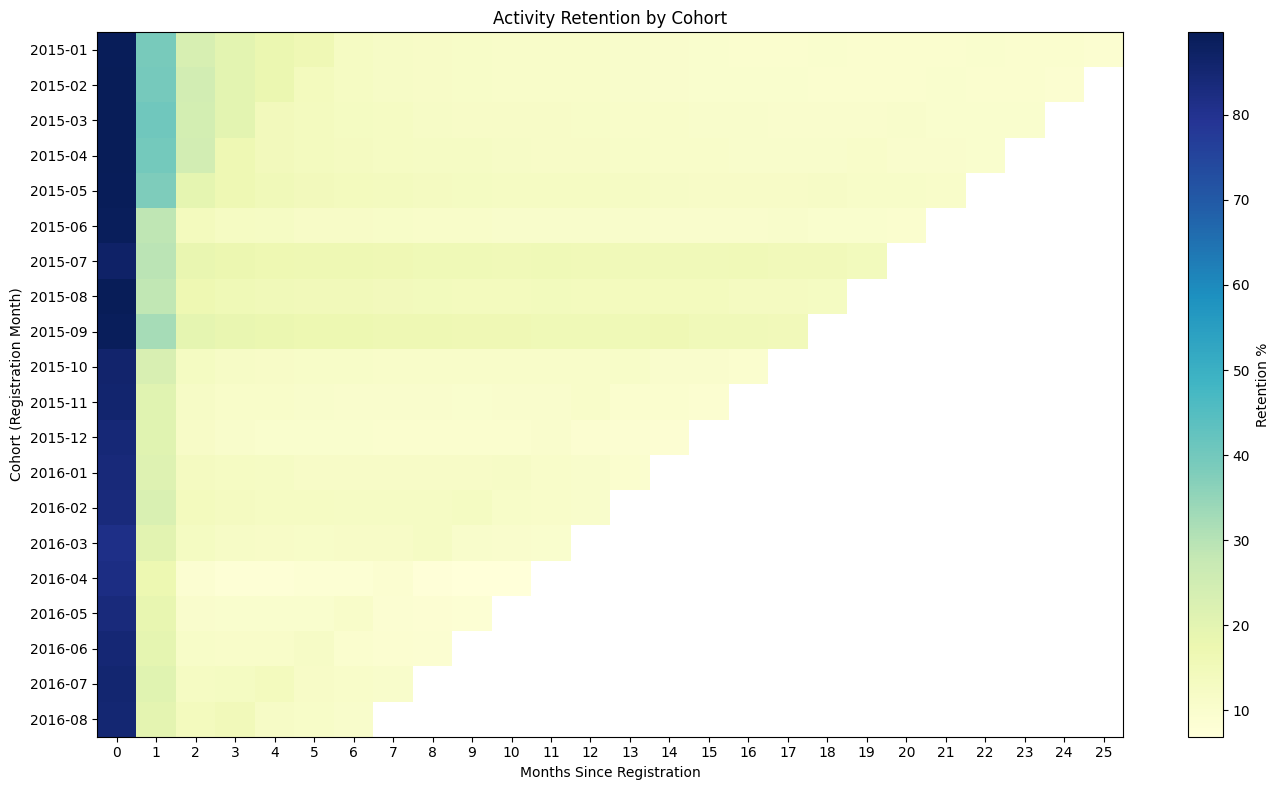

In [72]:
# Retention matrix heatmap
plt.figure(figsize=(14, 8))
plt.imshow(retention_matrix_df.values, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Retention %')
plt.xlabel('Months Since Registration')
plt.ylabel('Cohort (Registration Month)')
plt.yticks(range(len(retention_matrix_df.index)), retention_matrix_df.index)
plt.xticks(range(len(retention_matrix_df.columns)), retention_matrix_df.columns)
plt.title('Activity Retention by Cohort')
plt.tight_layout()
plt.show()

Retention drops sharply from Month 0 (83-89%) to Month 1 (17-40%), then stabilizes around 10-15% by Month 6. 2015 cohorts stabilize at 10-17% while 2016 cohorts stabilize at 8-12%.

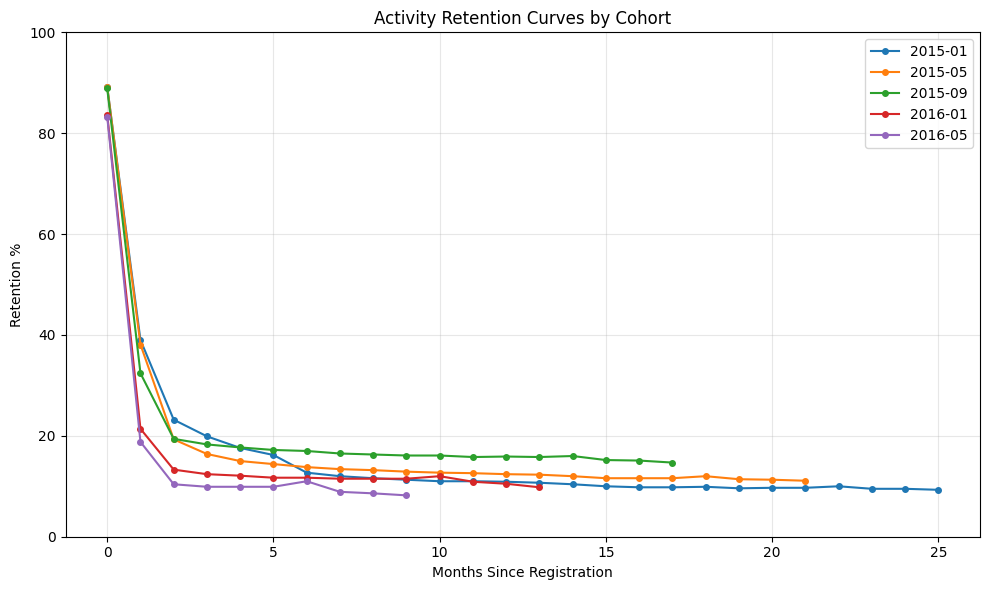

In [73]:
# Visualize retention curves for selected cohorts
fig, ax = plt.subplots(figsize=(10, 6))

all_cohorts = retention_matrix_df.index.tolist()
cohorts_to_plot = all_cohorts[::4]  # Every 4th cohort

for cohort in cohorts_to_plot:
    data = retention_matrix_df.loc[cohort].dropna()
    ax.plot(data.index, data.values, marker='o', label=cohort, markersize=4)

ax.set_xlabel('Months Since Registration')
ax.set_ylabel('Retention %')
ax.set_title('Activity Retention Curves by Cohort')
ax.legend()
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

All cohorts follow the same decay shape: steep drop in Month 1, gradual decline through Month 6, then flat. The 2015-07 and 2015-09 cohorts retain highest (~15-17%), while 2016-04 retains lowest (~8%)

## Summary

**Methodology:** Activity-based cohort retention using all users who registered Jan 2015 through Aug 2016. Retention is measured by listening activity in each month after registration.

**Key findings:**
- Month 0 retention is 83-89% (not all users listen in their registration month)
- Sharpest drop occurs in Month 1, falling to 17-40% depending on cohort
- Retention stabilizes around 10-15% for long-term engaged users
- 2015 cohorts stabilize higher (10-17%) than 2016 cohorts (8-12%) 